## Forecasting using time series models

In this notebook we try to predict the weekly sales for the last 8 weeks using time series techniques.

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
import warnings
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

sns.set_palette("Set2")
%matplotlib inline
warnings.filterwarnings('ignore')

#### Definition of Helper Functions

In [2]:
def error_table(model_name, y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [model_name])

#### Read data

In [3]:
y_train = pd.read_csv("../data/y_train.csv", parse_dates=['Date'], index_col=['Store', 'Date'])
y_test = pd.read_csv("../data/y_test.csv", parse_dates=['Date'], index_col=['Store', 'Date'])
display(y_train)

Sales
Store Date                 
1     2015-06-01  10.122543
      2015-05-25  10.255130
      2015-05-18  10.019536
      2015-05-11   9.972780
      2015-05-04  10.212185
...                     ...
1115  2013-01-28  10.260707
      2013-01-21  10.302532
      2013-01-14  10.036663
      2013-01-07  10.229079
      2012-12-31  10.094562

[136726 rows x 1 columns]

#### Exploration of time series characteristics at a global level:  

We want to see whether the global sales time series has salient features that allow us to choose a suitable model.

In [4]:
# stack y_train and y_test vertically
y = pd.concat([y_train, y_test], axis=0)
# recover time series at its original scale
y['Sales'] = np.expm1(y['Sales'])
# aggregate the data by date
y_global = y.groupby('Date').sum()
y_global

,Sales
Date,
2012-12-31,36956183.0
2013-01-07,44335162.0
2013-01-14,37252051.0
2013-01-21,43157797.0
2013-01-28,42920978.0
...,...
2015-06-29,51314282.0
2015-07-06,44692076.0
2015-07-13,48506473.0


Let's plot the global time series together with its cummulative average. The shaded region corresponds to the weeks which we have to forecast.

In [5]:
y_global['SalesCumAvg'] = y_global['Sales'].expanding().mean()
# save for later use 
y_global.to_csv("../data/y_global.csv")

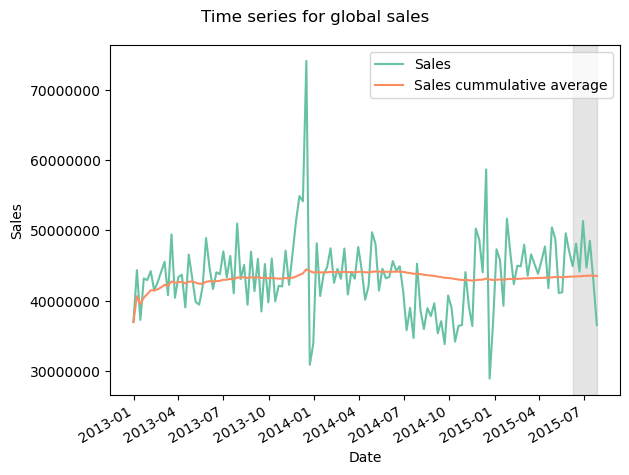

In [6]:
fig, ax = plt.subplots()

ax.plot(y_global.index, y_global['Sales'], label='Sales')
ax.plot(y_global.index, y_global['SalesCumAvg'], label='Sales cummulative average')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.axvspan(datetime(2015,6,8), datetime(2015,7,27), color='#808080', alpha=0.2)
ax.legend(loc='upper right')

fig.autofmt_xdate()
fig.suptitle('Time series for global sales')
# to avoid scientific notation in y ticks
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout();

Now I would like to see how the decomposition of this time series looks like for different periods (in weeks):

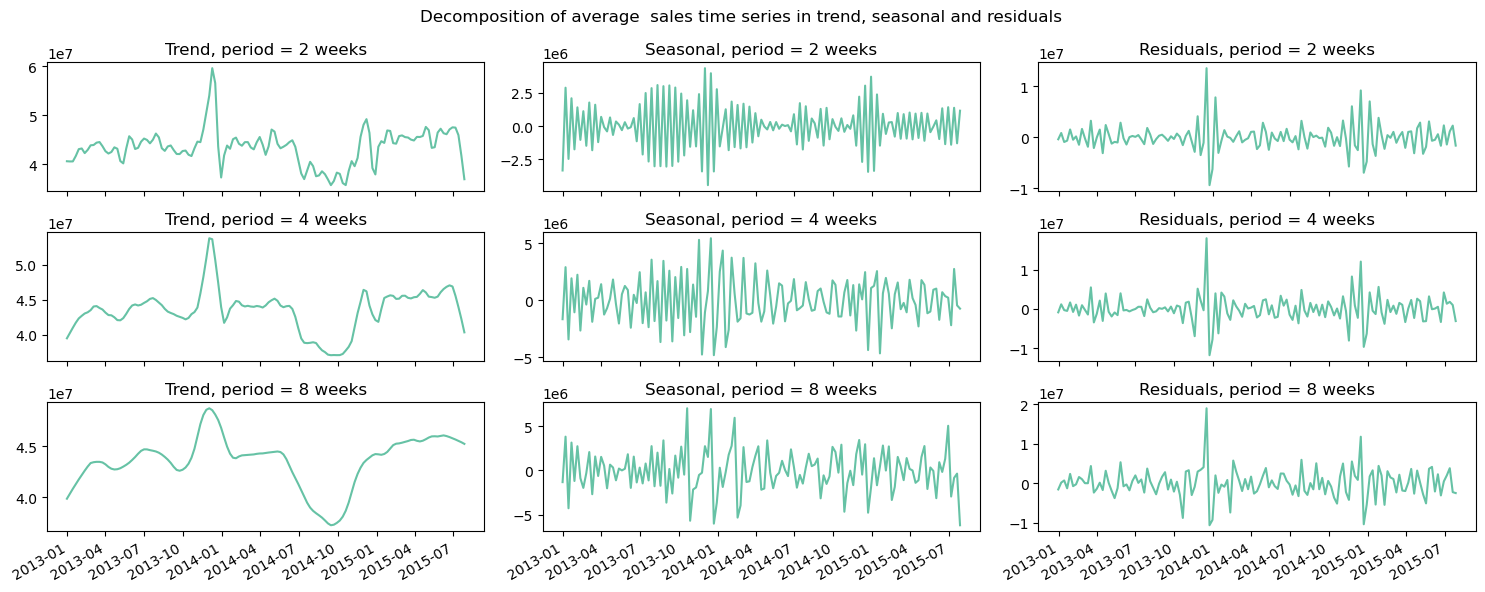

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(15,6))

for i, p in enumerate([2, 4, 8]): 
    decomposition = STL(y_global['Sales'], period=p).fit()
    # Trend
    axs[i, 0].plot(decomposition.trend)
    axs[i, 0].set_title(f'Trend, period = {p} weeks')
    # Seasonal
    axs[i, 1].plot(decomposition.seasonal)
    axs[i, 1].set_title(f'Seasonal, period = {p} weeks')
    # Residuals
    axs[i, 2].plot(decomposition.resid)
    axs[i, 2].set_title(f'Residuals, period = {p} weeks')
    
fig.suptitle('Decomposition of average  sales time series in trend, seasonal and residuals')
fig.autofmt_xdate()
plt.tight_layout();

Let's take a look at the plot of the  log-scaled `Sales` time series and its cummulative mean:

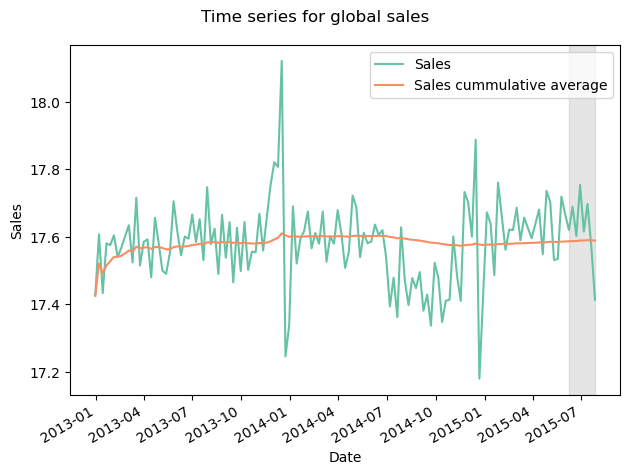

In [8]:
y_global['Sales'] = np.log1p(y_global['Sales'])
y_global['SalesCumAvg'] = np.log1p(y_global['SalesCumAvg'])

fig, ax = plt.subplots()

ax.plot(y_global.index, y_global['Sales'], label='Sales')
ax.plot(y_global.index, y_global['SalesCumAvg'], label='Sales cummulative average')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.axvspan(datetime(2015,6,8), datetime(2015,7,27), color='#808080', alpha=0.2)
ax.legend(loc='upper right')

fig.autofmt_xdate()
fig.suptitle('Time series for global sales')
# to avoid scientific notation in y ticks
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout();

#### Time series preprocessing

The plot after log-scalig looks quite similiar to the original one. From these plots, I see that the mean seems to remain stable but there some abrupt variations happening at ceratin times. Let's see what the augmented Dickey-Fuller test has to say about the stationarity of this process.

- The Hypothesis: The test has a null hypothesis that the data has a unit root, which means it’s not stationary  
- The alternative hypothesis is that the data is stationary or trend-stationary.  
- The Output: The ADF test gives you a test statistic, a p-value, and critical values at different significance - levels (like 1% or 5%).  
- Interpreting the p-value: A low p-value (less than your chosen significance level) means you reject the null hypothesis. In this case, that means the data is likely stationary.  
- Interpreting the test statistic: The test statistic is negative. The more negative it is, the stronger the evidence against the null hypothesis (i.e., stronger evidence for stationarity)

In [9]:
#Run the augmented Dickey-Fuller test to check if we are dealing with a sationary process:
ADF_result = adfuller(y_global['Sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -4.925740030853858
p-value: 3.1066635655455244e-05


So, according to the AFD test, the data is already stationary. Nevertheless, let's differenciate the time series to see if that helps to smooth out the abrupt jumps (variance).

In [10]:
y_global['SalesDiff'] = y_global['Sales'].diff()
# we have a nan at the first position
y_global['SalesDiff'].fillna(0, inplace=True)

Plot differences:

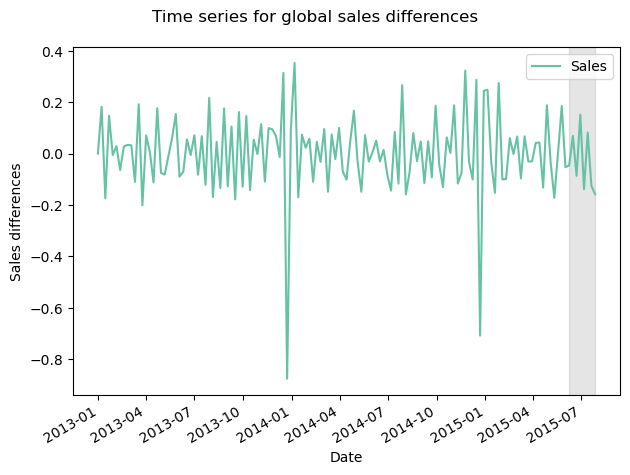

In [11]:
fig, ax = plt.subplots()

ax.plot(y_global.index, y_global['SalesDiff'], label='Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales differences')
ax.axvspan(datetime(2015,6,8), datetime(2015,7,27), color='#808080', alpha=0.2)
ax.legend(loc='upper right')

fig.autofmt_xdate()
fig.suptitle('Time series for global sales differences')
# to avoid scientific notation in y ticks
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout();

Run ADF test with the differences:

In [12]:
ADF_result = adfuller(y_global['SalesDiff'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.689862617284419
p-value: 4.06818173626537e-14


The ADF statistic has a larger negative value and the p-value is also smaller, so that it seems to be a good idea to work with the differenciated time series.

Let's take a look at the ACF and PACF plots of the differences to see if we can recognize some pattern:

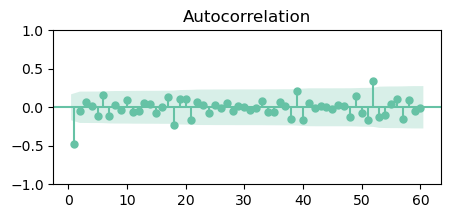

In [13]:
fig, ax = plt.subplots(figsize=(5,2))

plot_acf(y_global['SalesDiff'], zero=False, lags=60, ax=ax);

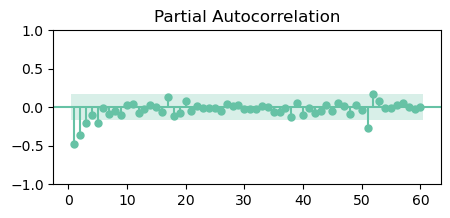

In [14]:
fig, ax = plt.subplots(figsize=(5,2))
plot_pacf(y_global['SalesDiff'], zero=False, lags=60, ax=ax);

I cannot recognize a clear pattern of autoregressive or moving average model. Nevertheless, the coefficients in the PACF plot corresponding to the 1st, 2nd, 3rd, 5th 52th and 53th lags lie outside the shaded region and are therefore significant. As a first modelling attempt, I will train an autoregessive process on these lags for each store.

##### Fill missing obervations in train data set with store mean 
As we saw earlier, there are stores which weren't open for several days. We would like to fill the missing obervations in the train data with the train mean in order to be able to perform time series regressions.

In [15]:
dates = y.index.get_level_values(1).unique().sort_values()
# 8 weeks before the last date
test_date = dates[-1] - timedelta(weeks=7)
y_train = y[y.index.get_level_values(1) < test_date]
y_test = y[y.index.get_level_values(1) >= test_date]

In [16]:
# sort data
y_train.sort_index(level=['Store', 'Date'], ascending=[True, True], inplace=True)
y_test.sort_index(level=['Store', 'Date'], ascending=[True, True], inplace=True)

In [17]:
# We will set the train data multiindex to be all possible combinations of stores and dates for the treining period 
stores = y.index.get_level_values(0).unique().sort_values()
train_index = pd.MultiIndex.from_product([stores, dates[dates < test_date]])
y_train = y_train.reindex(train_index)
# We have nans where there missing observations
y_train.isnull().sum()

Sales    4879
dtype: int64

We will fill the gaps in the train data with the train means:

In [18]:
# fill nans (=missing observations) with store means
train_avgs = y_train.groupby('Store').mean().rename({'Sales' : 'AvgSales'}, axis = 1)
y_train = y_train.join(train_avgs)
y_train['Sales'].fillna(y_train['AvgSales'], inplace=True)
y_train.isnull().sum()

Sales       0
AvgSales    0
dtype: int64

Log scale the train data:

In [19]:
y_train['Sales'] = np.log1p(y_train['Sales'])
y_train['AvgSales'] = np.log1p(y_train['AvgSales'])

For the train data, calculate sales differences for each store:

In [20]:
y_train['SalesDiff'] = y_train.groupby(level=0)['Sales'].diff()
# the first differences are nans, fill them with 0
y_train['SalesDiff'].fillna(0, inplace=True)
y_train.head()

Sales   AvgSales  SalesDiff
Store Date                                       
1     2012-12-31  10.185541  10.228754   0.000000
      2013-01-07  10.325285  10.228754   0.139744
      2013-01-14  10.190770  10.228754  -0.134516
      2013-01-21  10.365112  10.228754   0.174343
      2013-01-28  10.363157  10.228754  -0.001956

#### Autoregressive Model AR(p)

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

As we saw above, the coefficients for the 1st, 18th and 52th lags lie outisde the shaded area in the ACF and PACF plots. Therefore we will train an autoregressive model with these lags for each store as first attempt of a time series regression.

In [21]:
train_len = (dates < test_date).sum()
test_len = (dates >= test_date).sum()

test_dates = dates[dates >= test_date]

In [22]:
# revert to single index on date
y_train_1 = y_train.reset_index(level=[0])

y_ar_pred_list = []

# loop over stores
for s in np.sort(y_train_1['Store'].unique()):
    y_train_s = y_train_1[y_train_1['Store'] == s]['SalesDiff']
    # It's good to have also the store as part of the index
    s_index = pd.MultiIndex.from_product([[s], test_dates], names=['Store', 'Date'])
    # fit and predict
    ar_model = AutoReg(y_train_s, lags=[1,2,3,52,53])
    ar_results = ar_model.fit()
    y_pred_s = ar_results.predict(start=train_len, end=train_len + test_len - 1, dynamic=False)
    y_pred_s.index = s_index
    # append to list
    y_ar_pred_list.append(y_pred_s)

# concatenate series
y_ar_pred_diff = pd.concat(y_ar_pred_list)

As we trained a model on the differences, we must take the inverse transform of this operation:

In [23]:
# use last train value as offset (first predicted observation)
offset = y_train.groupby(level=0)['Sales'].tail(1)
offset.index = pd.MultiIndex.from_product([stores, [test_date]])
offset = offset.reindex(y_test.index)
offset.fillna(0, inplace=True)
# we want to predit only observations which are present in the test data
y_ar_pred_diff = y_ar_pred_diff.reindex(y_test.index)
# sum this offset to the differences
y_ar_pred = offset + y_ar_pred_diff
# accumulative sum on that
y_ar_pred = y_ar_pred.groupby(level=0).cumsum()
# return to original sacale
y_ar_pred = np.expm1(y_ar_pred)
# save for later use 
y_ar_pred.to_csv("../data/pred_ar.csv")

In [24]:
ar_errors = error_table('AR(1,2,3,5,52,53)', y_test, y_ar_pred)
ar_errors.to_csv("../data/ar_errors.csv")
ar_errors

,Model Name,MAE,MAPE,RMSE
"AR(1,2,3,5,52,53)","AR(1,2,3,5,52,53)",4141.852461,0.112542,6455.862889


#### Seasonal Integrated moving average model SARIMA(p,d,q)(P,D,Q)

To SARIMA model consists of the following components:  

- Seasonal Component (S): It refers to repeating patterns in the data. This could be daily, monthly, yearly, or any other regular interval.  
- Autoregressive (AR) Component: It models the relationship between the current data point and its past values.  
- Integrated (I) Component: The integrated component measures how many differences are required to achieve stationarity.  
- Moving Average (MA) Component: It models the dependency between the current data point and past prediction errors. It helps capture short-term noise in the data.

We will find the best model parameters in an automated way using the pmdarima package.

In [25]:
sarima_model = pmd.auto_arima(y_global['Sales'], start_p=1, start_q=1, test='adf', m=52, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=-211.685, Time=5.70 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-112.050, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-114.050, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-213.200, Time=5.06 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-181.265, Time=0.23 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=-211.965, Time=15.44 sec
 ARIMA(1,1,1)(2,0,1)[52] intercept   : AIC=-209.977, Time=26.04 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-214.922, Time=3.09 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-183.246, Time=0.14 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=-213.452, Time=31.49 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-213.462, Time=9.68 sec
 ARIMA(0,1,1)(2,0,1)[52] interc

We will the train a SARIMA(0,1,1)(1,0,0)[52] model for each store. We define first the following helping function:

In [26]:
def sarima_predictions(train_data, stores, order, seasonal_order):
    y_train_1 = train_data.reset_index(level=[0])
    y_sarima_pred_list = []
    for s in stores:
        y_train_s = y_train_1[y_train_1['Store'] == s]['Sales']
        # It's good to have also the store as part of the index
        s_index = pd.MultiIndex.from_product([[s], test_dates], names=['Store', 'Date'])
        # fit and predict
        sarima = SARIMAX(y_train_s, order=order, seasonal_order=seasonal_order, simple_differencing=False)
        y_pred_s = sarima.fit().predict(start=train_len, end=train_len + test_len - 1, dynamic=False)
        y_pred_s.index = s_index
        # append to list
        y_sarima_pred_list.append(y_pred_s)
    return y_sarima_pred_list

In [27]:
sarima_pred = pd.concat(sarima_predictions(y_train, range(1,1116), (0,1,1), (1,0,0,52)))

In [28]:
# we want to predit only observations which are present in the test data
sarima_pred = sarima_pred.reindex(y_test.index)
# return to original scale
sarima_pred = np.expm1(sarima_pred)
# save for later use 
sarima_pred.to_csv("../data/pred_sarima.csv")

In [29]:
sarima_errors = error_table('SARIMA(0,1,1)(1,0,0)[52]A', y_test, sarima_pred)
sarima_errors.to_csv("../data/sarima_errors.csv")
sarima_errors

,Model Name,MAE,MAPE,RMSE
"SARIMA(0,1,1)(1,0,0)[52]A","SARIMA(0,1,1)(1,0,0)[52]A",3737.105358,0.100979,6007.010634
